In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score

In [12]:
# Load training data
data = []
labels = []
classes = 43
cur_path = os.getcwd()

for i in range(classes):
    path = os.path.join(cur_path, 'Train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30, 30))
            image = np.array(image) / 255.0  # Normalize the image
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {a}: {e}")

data = np.array(data)
labels = np.array(labels)

# Convert labels to one-hot encoding
y_train = to_categorical(labels, num_classes=43)

C:\Users\angel\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4029 - loss: 2.2166
Epoch 2/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9289 - loss: 0.2350
Epoch 3/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9627 - loss: 0.1243
Epoch 4/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9745 - loss: 0.0844
Epoch 5/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9788 - loss: 0.0717
Epoch 6/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9820 - loss: 0.0579
Epoch 7/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9841 - loss: 0.0533
Epoch 8/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9849 - loss: 0.0514
Epoch 9/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9866 - loss: 0.0456
Epoch 10/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9870 - loss: 0.0431
Epoch 11/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9889 - loss: 0.0374
Epoch 12/15
613/613 ━━━━━━━━━━

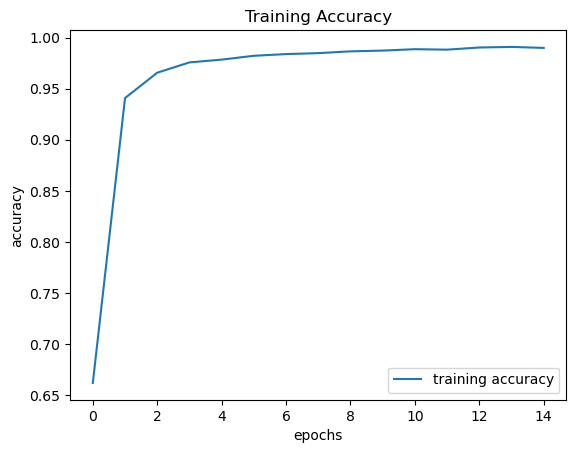

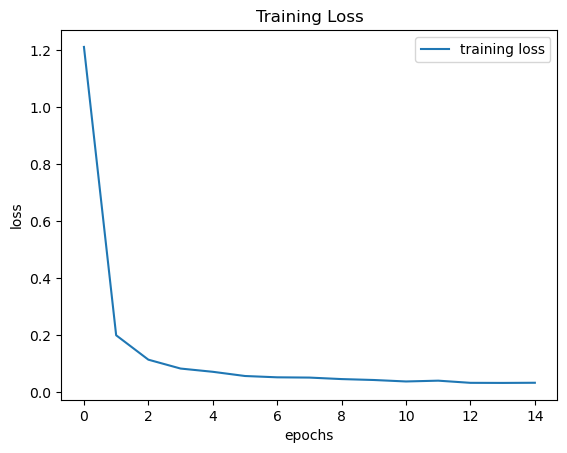

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Accuracy: 0.9698337292161521


In [23]:
# Build the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(30, 30, 3)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train on the entire training set (no validation split)
eps = 15
history = model.fit(data, y_train, batch_size=64, epochs=eps)

model.save("traffic_classifier.keras")

# Plot training accuracy and loss
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Load and evaluate on the original test set
y_test = pd.read_csv('Test.csv')
test_labels = y_test["ClassId"].values
imgs = y_test["Path"].values

test_data = []
for img in imgs:
    try:
        image = Image.open(img)
        image = image.resize((30, 30))
        image = np.array(image) / 255.0  # Normalize the test data
        test_data.append(image)
    except Exception as e:
        print(f"Error loading image {img}: {e}")

X_test = np.array(test_data)

# Predict and calculate accuracy
pred = np.argmax(model.predict(X_test), axis=-1)
print("Test Accuracy:", accuracy_score(test_labels, pred))

In [14]:
from keras.models import load_model

sign_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No overtaking',
    10: 'No overtaking by vehicles over 3.5 t',
    11: 'Intersection ahead – right-of-way only for this intersection',
    12: 'Priority road – right-of-way on all following intersections',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles of any kind permitted',
    16: 'No vehicles over 3.5 t permitted',
    17: 'No entry',
    18: 'Danger',
    19: 'Curve (left)',
    20: 'Curve (right)',
    21: 'Double curve (first left)',
    22: 'Uneven road',
    23: 'Slipperiness when road is wet or dirty',
    24: 'One-sided road narrowing (right)',
    25: 'Roadworks',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children',
    29: 'Cycles',
    30: 'Slipperiness due to snow or ice',
    31: 'Wild animals',
    32: 'End of all restrictions',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Go straight ahead',
    36: 'Go straight or turn right ahead',
    37: 'Go straight or turn left ahead',
    38: 'Pass on the right',
    39: 'Pass on the left',
    40: 'Roundabout',
    41: 'End of no overtaking',
    42: 'End of no overtaking by vehicles over 3.5 t'
}

categories = {
    'speed_limits': [0,1,2,3,4,5,7,8],
    'prohibitory': [9,10,15,16,17],
    'danger': [18,19,20,21,22,23,24,25,26,27,28,29,30,31],
    'mandatory': [33,34,35,36,37,38,39,40],
    'right_of_way': [11,12,13,14],
    'end_of': [32,41,42,6]
}

## Analiza eksploracyjna

Liczba obrazów na klasę:
count      43.000000
mean      911.837209
std       695.856715
min       210.000000
25%       345.000000
50%       600.000000
75%      1425.000000
max      2250.000000
Name: count, dtype: float64


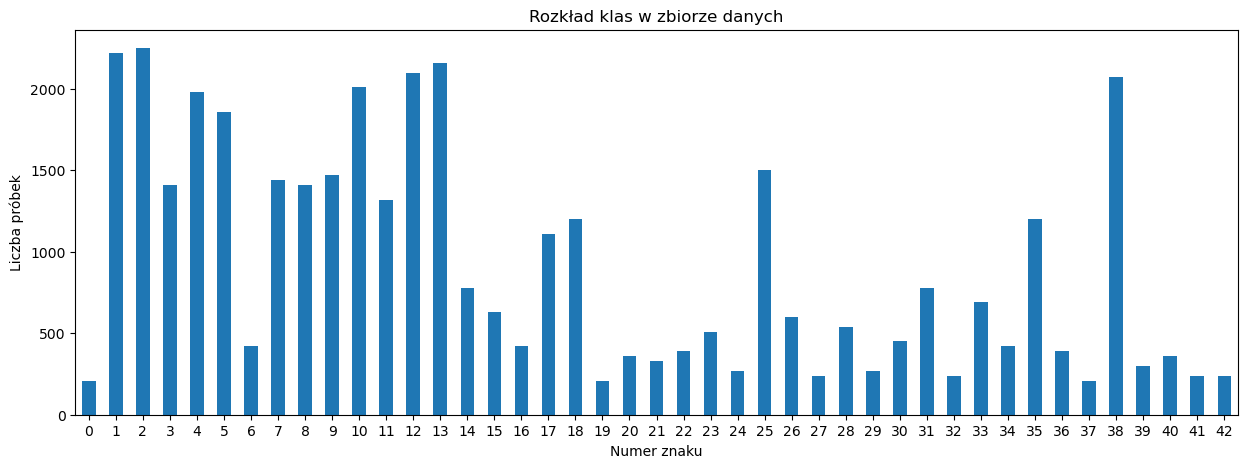

In [17]:
class_counts = pd.Series(labels).value_counts().sort_index()
print("Liczba obrazów na klasę:")
print(class_counts.describe())

plt.figure(figsize=(15,5))
class_counts.plot(kind='bar')
plt.title('Rozkład klas w zbiorze danych')
plt.xlabel('Numer znaku')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=0)
plt.show()

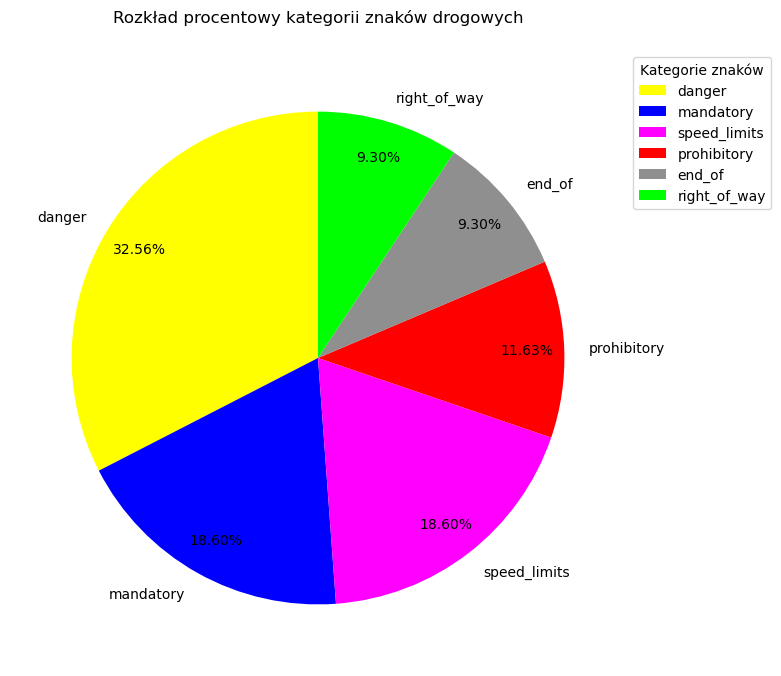


Liczba znaków w każdej kategorii:
category
danger          14
mandatory        8
speed_limits     8
prohibitory      5
end_of           4
right_of_way     4

Łącznie znaków regulacyjnych: 21


In [25]:
def get_category(class_id):
    for category, ids in categories.items():
        if class_id in ids:
            return category
    return 'unknown'

signs_df = pd.DataFrame({
    'class_id': list(sign_names.keys()),
    'sign_name': list(sign_names.values()),
    'category': [get_category(id) for id in sign_names.keys()]
})

category_distribution = signs_df.groupby('category')['class_id'].count().sort_values(ascending=False)
category_colors = {
    'speed_limits': '#FF00FF',
    'prohibitory': '#FF0000', 
    'danger': '#FFFF00',
    'mandatory': '#0000FF',
    'right_of_way': '#00FF00',
    'end_of': '#8F8F8F'
}

plt.figure(figsize=(10,8))
patches, texts, autotexts = plt.pie(
    category_distribution,
    labels=category_distribution.index,
    autopct='%.2f%%',
    colors=[category_colors[cat] for cat in category_distribution.index],
    startangle=90,
    pctdistance=0.85
)

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Kategorie znaków'
)

plt.title('Rozkład procentowy kategorii znaków drogowych', pad=20)
plt.show()

print("\nLiczba znaków w każdej kategorii:")
print(category_distribution.to_string())

regulatory_categories = ['speed_limits', 'mandatory', 'prohibitory', 'end-of', 'right-of-way']

regulatory_sum = signs_df[signs_df['category'].isin(regulatory_categories)].groupby('category')['class_id'].count()
print(f"\nŁącznie znaków regulacyjnych: {regulatory_sum.sum()}")

In [61]:
test_df = pd.read_csv('Test.csv')
y_true = test_df["ClassId"].values
test_image_paths = test_df["Path"].values

X_test = []
for img_path in test_image_paths:
    try:
        img_obj = Image.open(img_path)
        resized_img = img_obj.resize((30, 30))
        img_array = np.array(resized_img) / 255.0
        X_test.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

X_test = np.array(X_test)

model = load_model("traffic_classifier.keras")
raw_predictions = model.predict(X_test)
y_pred = np.argmax(raw_predictions, axis=1)

results = pd.DataFrame({
    'true_class': y_true,
    'pred_class': y_pred,
    'correct': y_true == y_pred
})

results['sign_name'] = results['true_class'].map(sign_names)
results['category'] = results['true_class'].apply(get_category)

class_counts = test_df['ClassId'].value_counts().sort_index()
overall_accuracy = accuracy_score(y_true, y_pred)
category_accuracy = results.groupby('category')['correct'].mean().sort_values(ascending=False)
sign_accuracy = results.groupby('true_class')['correct'].mean()

sign_accuracy_df = pd.DataFrame({
    'sign_id': sign_accuracy.index,
    'sign_name': sign_accuracy.index.map(sign_names),
    'category': sign_accuracy.index.map(lambda x: get_category(x)),
    'accuracy': sign_accuracy.values,
    'sample_count': class_counts.values
}).sort_values('accuracy', ascending=False)

print("Całkowita dokładność modelu:", overall_accuracy)
print("\n Dokładność według kategorii:")
print(category_accuracy.to_string())
print("\n Najlepiej rozpoznawane znaki:")
print(sign_accuracy_df.head(5).to_string(index=False))
print("\n Najgorzej rozpoznawane znaki:")
print(sign_accuracy_df.tail(5).to_string(index=False))

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Całkowita dokładność modelu: 0.9698337292161521

 Dokładność według kategorii:
category
mandatory       0.991525
speed_limits    0.981295
prohibitory     0.979032
right_of_way    0.963810
danger          0.942616
end_of          0.897222

 Najlepiej rozpoznawane znaki:
 sign_id                      sign_name     category  accuracy  sample_count
       0           Speed limit (20km/h) speed_limits       1.0            60
       9                  No overtaking  prohibitory       1.0           480
      40                     Roundabout    mandatory       1.0            90
      37 Go straight or turn left ahead    mandatory       1.0            60
      32        End of all restrictions       end_of       1.0            60

 Najgorzej rozpoznawane znaki:
 sign_id                       sign_name category  accuracy  sample_count
      21       Double curve (first left)   danger  0.855556            90
      30 Slipperiness due to snow or ice   dang

Najlepiej rozpoznawane znaki


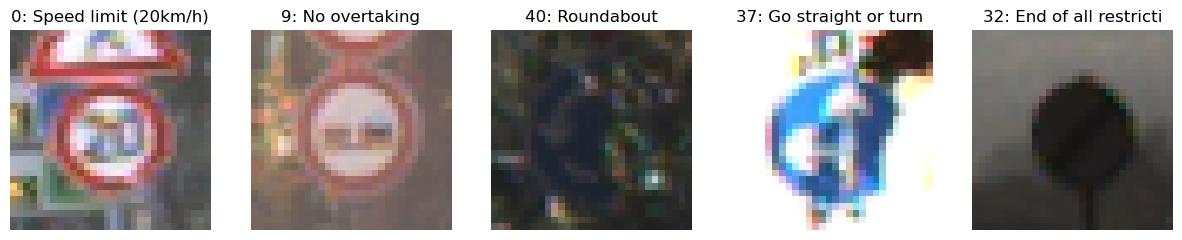

Najgorzej rozpoznawane znaki


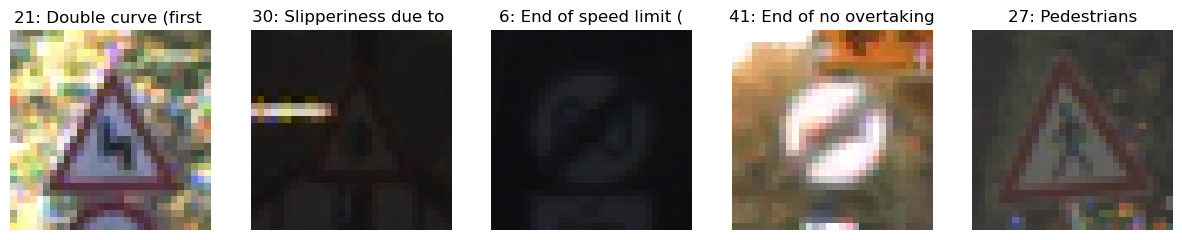

In [81]:
#pokazanie najlepiej i najgorzej rozpoznawanych znaków
best_signs = sign_accuracy_df.head(5)['sign_id'].values
worst_signs = sign_accuracy_df.tail(5)['sign_id'].values
def display_sign_examples(sign_ids):
    plt.figure(figsize=(15, 3))
    
    for i, sign_id in enumerate(sign_ids):
        index = np.where(labels == sign_id)[0][0]
        img = data[index]
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{sign_id}: {sign_names[sign_id][:20]}")
        plt.axis('off')
    
    plt.show()

print('Najlepiej rozpoznawane znaki')
display_sign_examples(best_signs)
print('Najgorzej rozpoznawane znaki')
display_sign_examples(worst_signs)

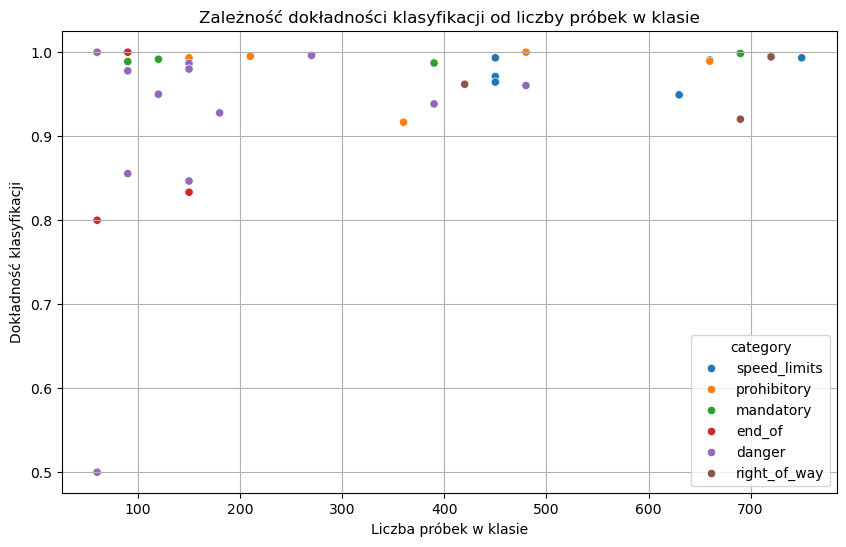

In [65]:
#zależność dokładności od liczby próbek
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sign_accuracy_df, x='sample_count', y='accuracy', hue='category')
plt.title('Zależność dokładności klasyfikacji od liczby próbek w klasie')
plt.xlabel('Liczba próbek w klasie')
plt.ylabel('Dokładność klasyfikacji')
plt.grid(True)
plt.show()

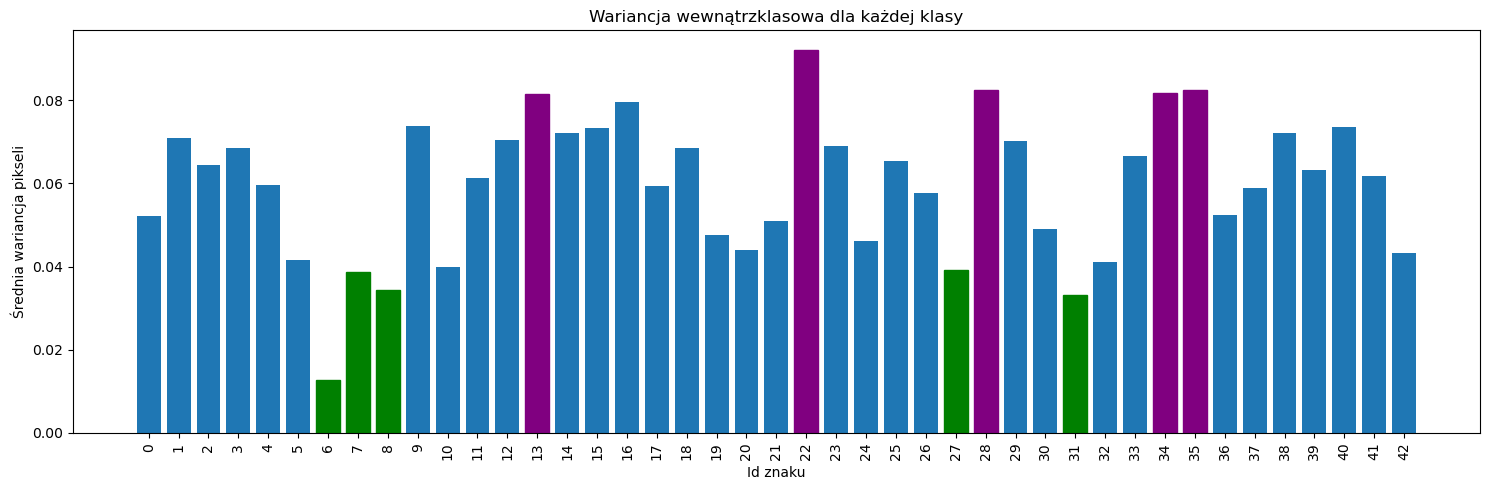


Klasy o najmniejszej wariancji wewnątrzgrupowej:
 sign_id                   sign_name     category  intra_class_var  sample_count
       6 End of speed limit (80km/h)       end_of         0.012840           420
      31                Wild animals       danger         0.033176           780
       8       Speed limit (120km/h) speed_limits         0.034454          1410
       7       Speed limit (100km/h) speed_limits         0.038815          1440
      27                 Pedestrians       danger         0.039103           240

Klasy o największej wariancji wewnątrzgrupowej:
 sign_id         sign_name     category  intra_class_var  sample_count
      13             Yield right_of_way         0.081437          2160
      34   Turn left ahead    mandatory         0.081651           420
      35 Go straight ahead    mandatory         0.082345          1200
      28          Children       danger         0.082364           540
      22       Uneven road       danger         0.092202    

In [127]:
# obliczanie wariancji wewnątrzgrupowej
intra_class_var = []
class_counts = []

for class_id in range(43):
    imgs = data[labels == class_id]
    class_counts.append(len(imgs))
    intra_class_var.append(np.mean(np.var(imgs, axis=0)))

intra_var_df = pd.DataFrame({
    "sign_id": range(43),
    "sign_name": [sign_names[i] for i in range(43)],
    "category": [get_category(i) for i in range(43)],
    "intra_class_var": intra_class_var,
    "sample_count": class_counts
})

plt.figure(figsize=(15, 5))
x = np.arange(len(intra_var_df))
bars = plt.bar(x, intra_var_df["intra_class_var"])
plt.title("Wariancja wewnątrzklasowa dla każdej klasy")
plt.xlabel("Id znaku")
plt.ylabel("Średnia wariancja pikseli")
plt.xticks(x, intra_var_df["sign_id"], rotation=90)

smallest_idx = np.argsort(intra_class_var)[:5]
largest_idx = np.argsort(intra_class_var)[-5:]

for i in smallest_idx:
    bars[i].set_color("green")
for i in largest_idx:
    bars[i].set_color("purple")

plt.tight_layout()
plt.show()

print("\nKlasy o najmniejszej wariancji wewnątrzgrupowej:")
print(intra_var_df.iloc[smallest_idx].to_string(index=False))

print("\nKlasy o największej wariancji wewnątrzgrupowej:")
print(intra_var_df.iloc[largest_idx].to_string(index=False))

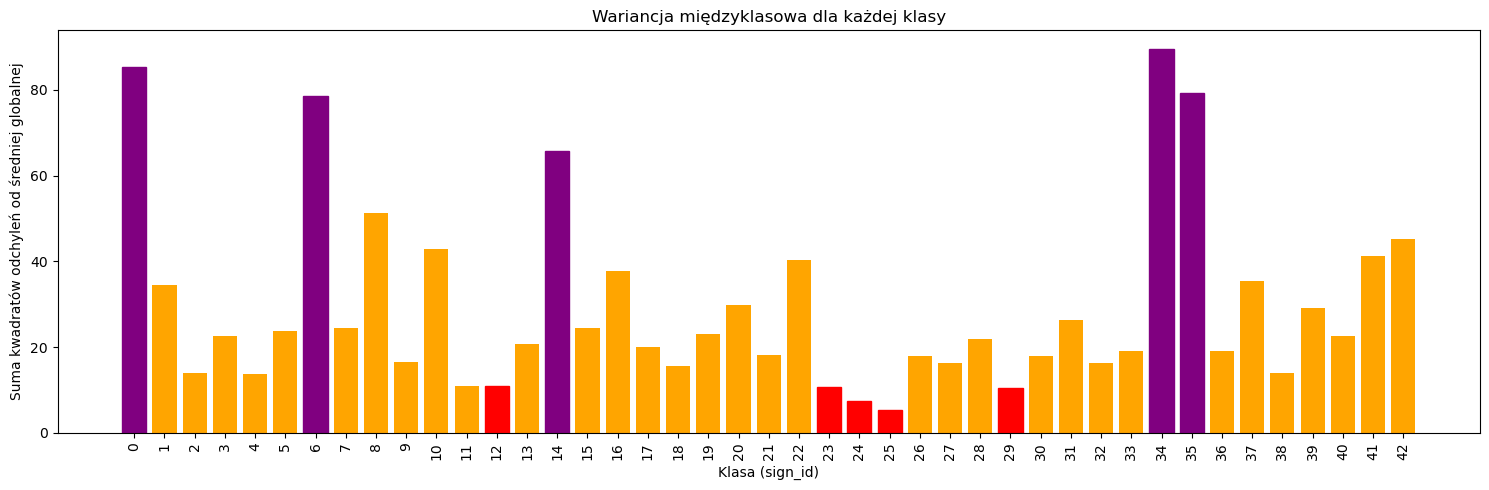


Klasy o najmniejszej wariancji międzyklasowej:
 sign_id                                                   sign_name     category  between_class_var
      25                                                   Roadworks       danger           5.355185
      24                            One-sided road narrowing (right)       danger           7.409788
      29                                                      Cycles       danger          10.387263
      23                      Slipperiness when road is wet or dirty       danger          10.727161
      12 Priority road – right-of-way on all following intersections right_of_way          10.855404

Klasy o największej wariancji międzyklasowej:
 sign_id                   sign_name     category  between_class_var
      14                        Stop right_of_way          65.636631
       6 End of speed limit (80km/h)       end_of          78.696845
      35           Go straight ahead    mandatory          79.244454
       0        Speed l

In [129]:
# obliczanie wariancji międzyklasowej
class_means = np.array([data[labels == i].mean(axis=0) for i in range(43)])
global_mean = data.mean(axis=0)
between_class_var = np.array([np.sum((class_means[i] - global_mean) ** 2) for i in range(43)])

between_var_df = pd.DataFrame({
    "sign_id": range(43),
    "sign_name": [sign_names[i] for i in range(43)],
    "category": [get_category(i) for i in range(43)],
    "between_class_var": between_class_var
})

plt.figure(figsize=(15, 5))
x = np.arange(len(between_var_df))
bars = plt.bar(x, between_var_df["between_class_var"], color="orange")
plt.title("Wariancja międzyklasowa dla każdej klasy")
plt.xlabel("Klasa (sign_id)")
plt.ylabel("Suma kwadratów odchyleń od średniej globalnej")
plt.xticks(x, between_var_df["sign_id"], rotation=90)

smallest_idx = np.argsort(between_class_var)[:5]
largest_idx = np.argsort(between_class_var)[-5:]

for i in smallest_idx:
    bars[i].set_color("red")
for i in largest_idx:
    bars[i].set_color("purple")

plt.tight_layout()
plt.show()

print("\nKlasy o najmniejszej wariancji międzyklasowej:")
print(between_var_df.iloc[smallest_idx].to_string(index=False))

print("\nKlasy o największej wariancji międzyklasowej:")
print(between_var_df.iloc[largest_idx].to_string(index=False))

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


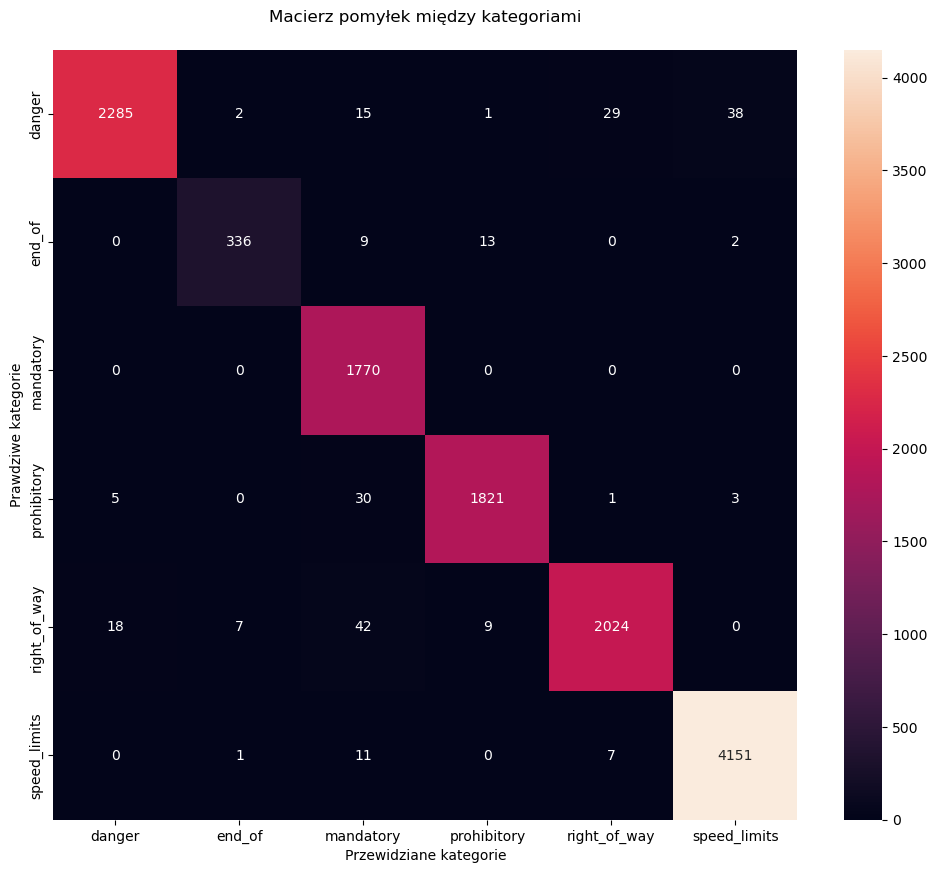

In [131]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = load_model("traffic_classifier.keras")
test_df = pd.read_csv('Test.csv')
y_true = test_df["ClassId"].values

y_pred = model.predict(X_test).argmax(axis=1)

y_true_cat = [get_category(x) for x in y_true]
y_pred_cat = [get_category(x) for x in y_pred]
categories_order = sorted(set(y_true_cat))

plt.figure(figsize=(12, 10))
cat_cm = confusion_matrix(y_true_cat, y_pred_cat, labels=categories_order)
sns.heatmap(cat_cm, annot=True, fmt='d',
            xticklabels=categories_order,
            yticklabels=categories_order)
plt.title('Macierz pomyłek między kategoriami', pad=20)
plt.xlabel('Przewidziane kategorie')
plt.ylabel('Prawdziwe kategorie')
plt.show()


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


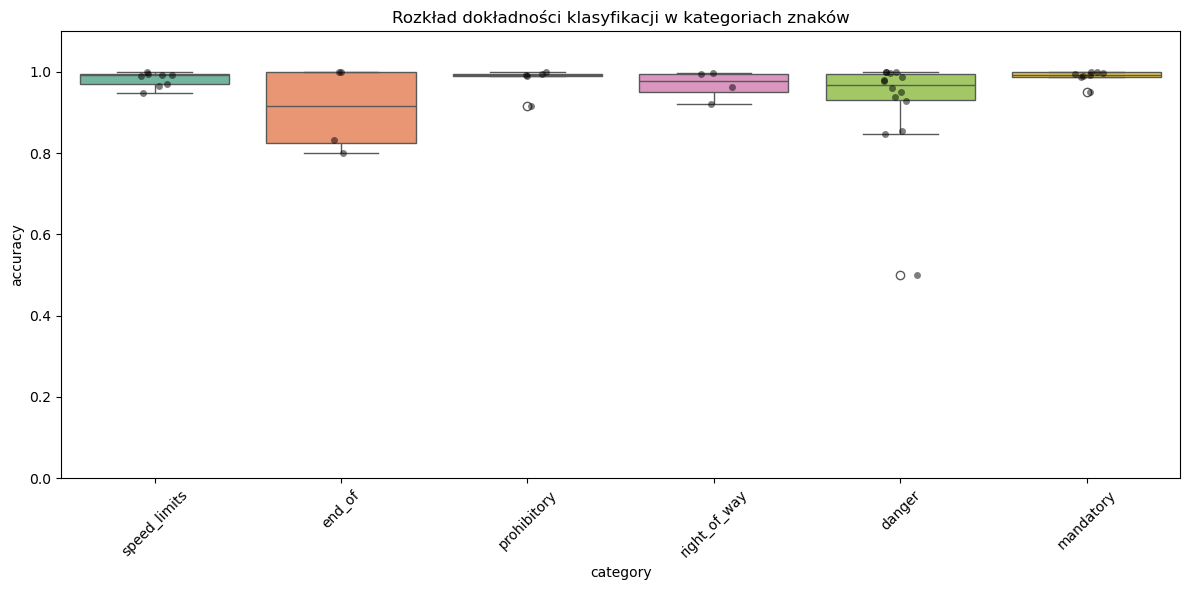

In [133]:
model = load_model("traffic_classifier.keras")
test_df = pd.read_csv('Test.csv')
y_true = test_df["ClassId"].values

y_pred = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
class_accuracy = np.diag(cm) / cm.sum(axis=1)

results_df = pd.DataFrame({
    'class_id': range(43),
    'sign_name': [sign_names[i] for i in range(43)],
    'accuracy': class_accuracy,
    'category': [get_category(i) for i in range(43)]
})

plt.figure(figsize=(12,6))
sns.boxplot(x='category', y='accuracy', hue='category', data=results_df, 
            palette='Set2', legend=False)
sns.stripplot(x='category', y='accuracy', color='black', alpha=0.5, data=results_df)
plt.title('Rozkład dokładności klasyfikacji w kategoriach znaków')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()